# KimmelNet

Welcome to KimmelNet! If you have set up your python environment correctly, by following [the instructions on GitHub](https://github.com/djpbarry/KimmelNET/tree/main#run-kimmelnet-on-your-own-data), then clicking the _Run All_ button above should result in all the code below being successfully executed - you should see plenty of graphical output (and no errors!). But let's go through each cell one by one.

This first cell just gets everything set up - unless you are familiar with the inner workings of TensorFlow, you probably don't want to change anything here!

Note that the expected size of the input images is 268 x 224 pixels (width x height). Don't worry if your images are a different size - they will be scaled automatically. However, if the aspect ratio of your images is substantially different to this, then KimmelNet may not perform terribly well.

In [1]:
import os

import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from scipy.optimize import curve_fit
from sklearn.metrics import r2_score
from tensorflow import keras


def func(x, a):
    return a * x


# Variables pertaining to trained model

image_size = (224, 268)
cropped_image_size = (224, 224)
batch_size = 32
buffer_size = 4

These next variables are two that you _may_ wish to change. By default, they point to the location of the sample test data and pretrained KimmelNet model. However, if your test data is  located elsewhere, or you want to use a version of KimmelNet you have updated yourself (by way of transfer learning or otherwise), you will need to specify the relevant paths here:

In [2]:
test_path = './test_data'
model_path = './KimmelNet_Model/published_model_multi_gpu_custom_augmentation_trained_model'

That's it! You don't need to do anything else.

If you run this next cell, all your test data will be parsed and loaded into a dataset - you should see the total number of images in the dataset displayed.

In [3]:
# parse_image function returns an image and the image's label (which is given by the name of the folder in which
# the image is saved) given a filename
def parse_image(filename):
    parts = tf.strings.split(filename, os.sep)
    label = float(parts[-2])
    image = tf.io.read_file(filename)
    image = tf.image.decode_png(image)
    image = tf.image.resize(image, image_size)
    return image, label


# Construct a tensorflow Dataset based on the file list in the test_path parent directory
test_list_ds = tf.data.Dataset.list_files(str(test_path + os.sep + "*" + os.sep + "*.png")).shuffle(1000)
test_ds = test_list_ds.map(parse_image).batch(batch_size)
test_ds = test_ds.prefetch(tf.data.AUTOTUNE).cache()

print("Number of images in test dataset: ", test_list_ds.cardinality().numpy())

Number of images in test dataset:  46


In this next cell, the KimmelNet model is loaded and a summary of the model is displayed:

In [4]:
# Load and display a summary of the trained model

model = keras.models.load_model(model_path)

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 random_flip (RandomFlip)    (None, 224, 268, 1)       0         
                                                                 
 random_translation (RandomT  (None, 224, 268, 1)      0         
 ranslation)                                                     
                                                                 
 random_zoom (RandomZoom)    (None, 224, 268, 1)       0         
                                                                 
 rescaling (Rescaling)       (None, 224, 268, 1)       0         
                                                                 
 center_crop (CenterCrop)    (None, 224, 224, 1)       0         
                                                                 
 conv2d (Conv2D)             (None, 222, 222, 128)     1280      
                                                        

Next, we display a sample selection of the test dataset, to ensure everything is behaving as it should be:

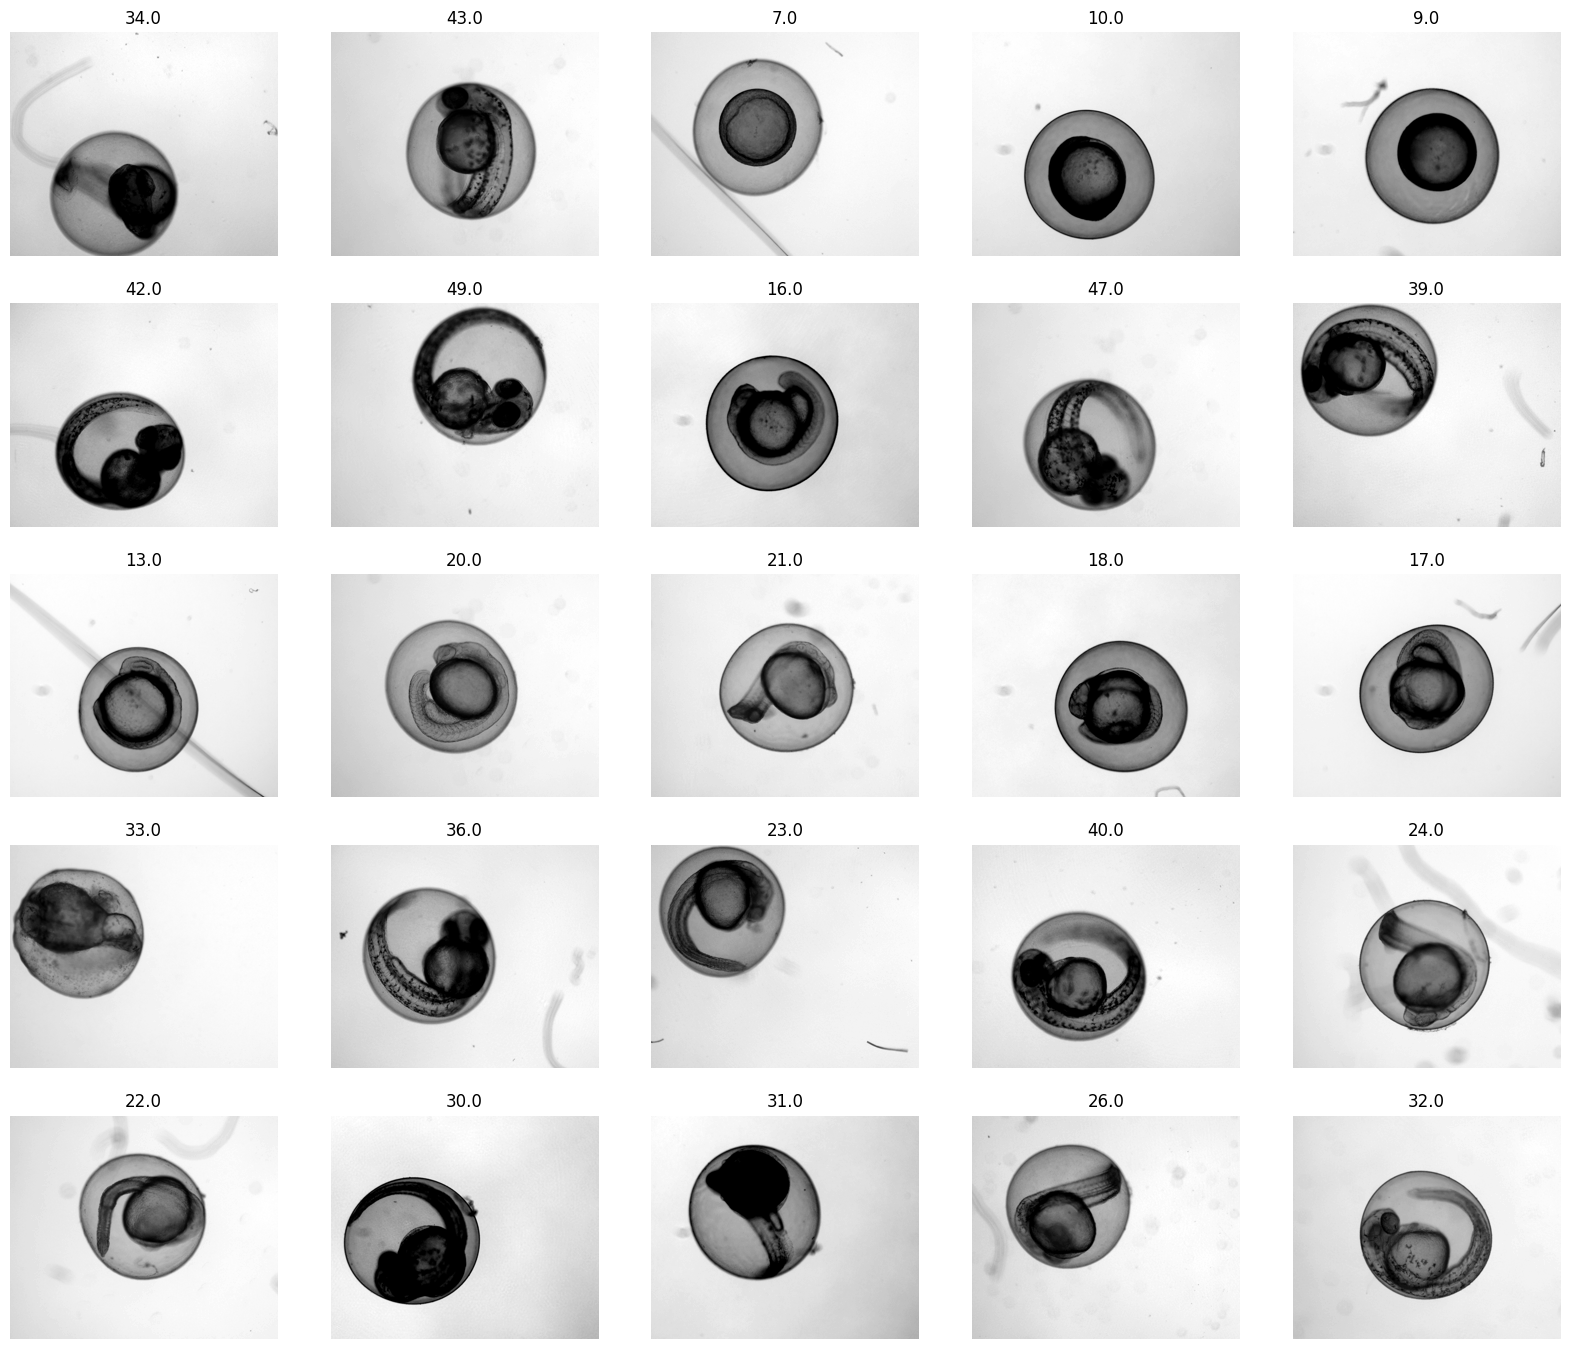

In [5]:
# Display a sample of the test data

%matplotlib inline

plt.figure(num=3, figsize=(20, 17))
for images, labels in test_ds.take(1):
    for i in range(25):
        ax = plt.subplot(5, 5, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"), cmap='gray')
        plt.title(labels[i].numpy())
        plt.axis("off")
plt.show()

Now we get on to running KimmelNet on the test data. Here, you should see a "Test Loss" displayed for the entire test dataset. This value tells you how (in)accurate KimmelNet has been at predicting the true hours post-fertilisation for all the images in your test data. Note that this value has units of hours<sup>2</sup>, so take the square root to get the mean error in hours. Consult the manuscript describing KimmelNet to get an idea of what kind of error values you can expect.

In [6]:
# Evaluate the model on all the test data

score = model.evaluate(test_ds, verbose=1)
print("Test loss:", score)

2/2 [==============================] - 2s 346ms/step - loss: 4.4334
Test loss: 4.433413505554199


Now we plot the predictions for each individual image against the true hpf for that image and fit a line to the resulting point cloud.

1/1 [==============================] - 0s 441ms/step


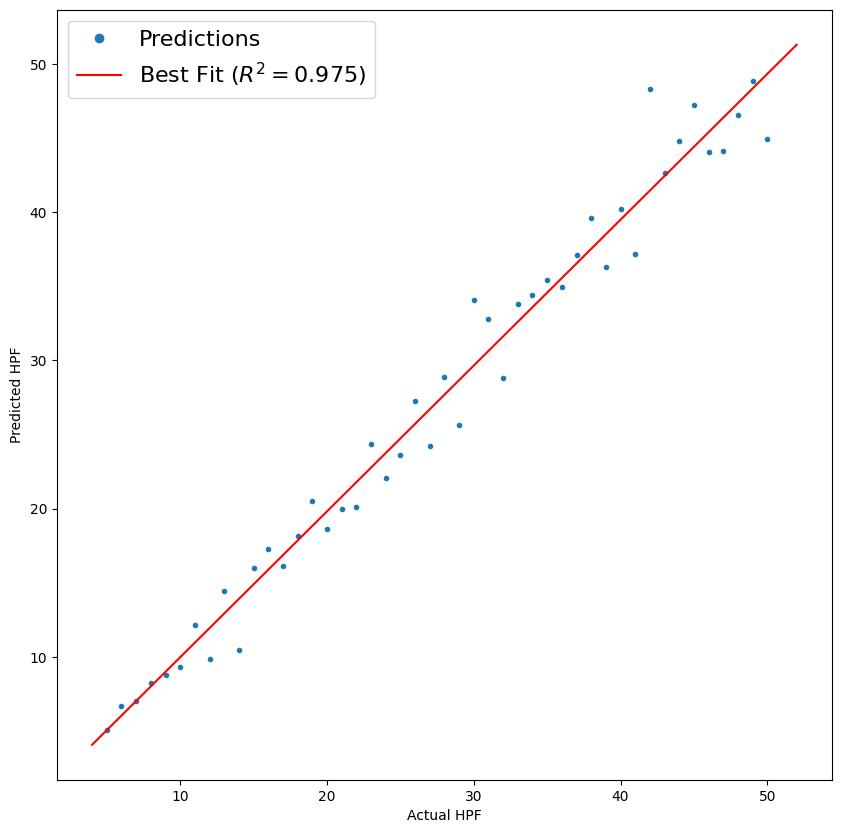

In [12]:
# Plot the prediction accuracy on an image-by-image basis - each datapoint represents a single image in the test data

labels = np.array([])
predictions = np.array([])
for x, y in test_ds:
    p = model.predict(x, verbose=1)
    for i in range(len(p)):
        predictions = np.concatenate([predictions, p[i]])
    labels = np.concatenate([labels, y.numpy()])

linear_model = np.polyfit(labels, predictions, 1)
linear_model_fn = np.poly1d(linear_model)
popt, pcov = curve_fit(func, labels, predictions)
r2 = r2_score(predictions, func(labels, popt))

x_s = np.arange(4, 53)

plt.figure(num=2, figsize=(10, 10))
plt.plot(labels, predictions, 'o', markersize=3, label='Predictions')
plt.plot(x_s, linear_model_fn(x_s), color="red", label="Best Fit ($R^2 = {{{:.3f}}}$)".format(r2))
plt.xlabel("Actual HPF")
plt.ylabel("Predicted HPF")
plt.legend(fontsize=16, markerscale=2.0)
plt.show()

Finally, we produce a plot of the distribution of prediction errors:

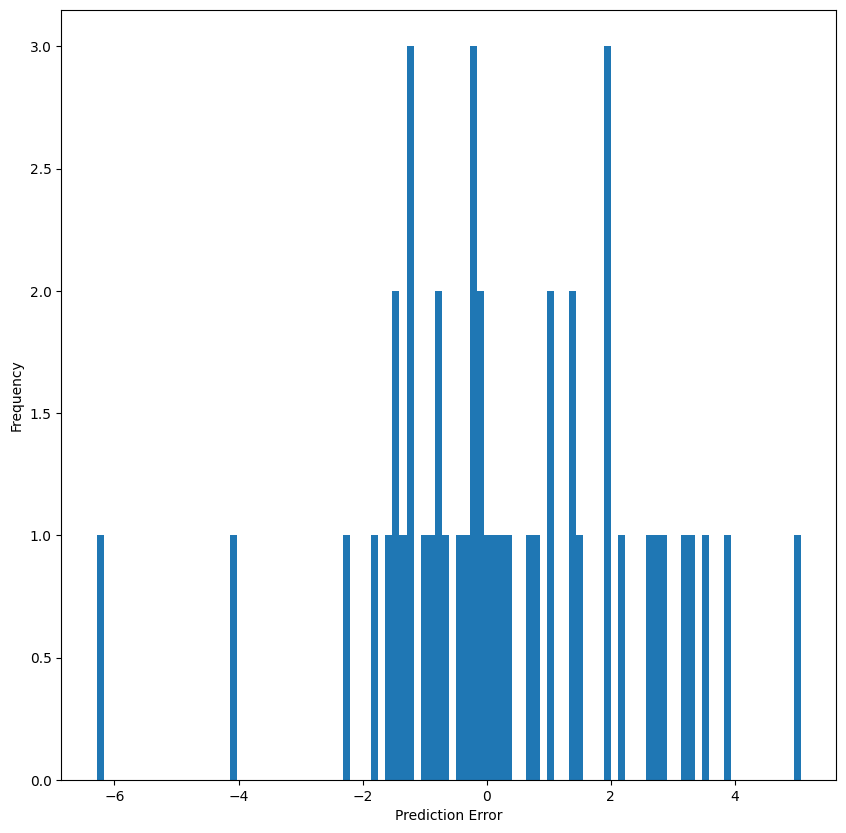

In [8]:
# Plot the distribution of errors (the differences between predictions and true la)

errs = labels - predictions

plt.figure(num=4, figsize=(10, 10))
plt.hist(errs, bins=100)
plt.xlabel("Prediction Error")
plt.ylabel("Frequency")
plt.show()